In [237]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [238]:
def get_main_object(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    borders = cv2.Canny(blur, 30, 150)
    
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(borders, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour_obj = contours[0]

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour_obj], -1, 255, -1)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Ajustar a imagem para ser quadrada 
    h, w = closing.shape[:2]

    max_dim = max(h, w)

    top = (max_dim - h) // 2
    bottom = max_dim - h - top
    left = (max_dim - w) // 2
    right = max_dim - w - left

    squared_image = cv2.copyMakeBorder(closing, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])

    return squared_image

In [239]:
def orientation_from_fourier_paper(
    image,
    angle_range=90,
    precision=1.0,
    xi_min_ratio=0.04
):
    if image.ndim != 2:
        raise ValueError("A imagem deve ser 2D")

    h, w = image.shape
    fft_result = np.fft.fftshift(np.fft.fft2(image))
    psd = np.abs(fft_result)**2

    center_x, center_y = w // 2, h // 2
    y, x = np.ogrid[-center_y:h-center_y, -center_x:w-center_x]
    dist_from_center = np.sqrt(x**2 + y**2)

    xi_min = xi_min_ratio * max(h, w)
    n_max = min(center_x, center_y)

    mask = (dist_from_center >= xi_min) & (dist_from_center <= n_max)
    filtered_psd = psd * mask

    angles = np.arange(-angle_range, angle_range, precision)
    g_theta = np.zeros(len(angles))

    Y, X = np.ogrid[-center_y:h-center_y, -center_x:w-center_x]
    theta_grid = np.arctan2(Y, X)
    theta_grid_deg = np.rad2deg(theta_grid)

    angular_tolerance = max(precision * 0.75, 0.5)

    for i, target_angle in enumerate(angles):
        angle_diff = np.abs(theta_grid_deg - target_angle)
        mask1 = angle_diff <= angular_tolerance

        symmetric_angle = target_angle + 180 if target_angle < 0 else target_angle - 180
        angle_diff_sym = np.abs(theta_grid_deg - symmetric_angle)
        mask2 = angle_diff_sym <= angular_tolerance

        if abs(target_angle) > 180 - angular_tolerance:
            if target_angle > 0:
                wrapped_angle = target_angle - 360
                angle_diff_wrap = np.abs(theta_grid_deg - wrapped_angle)
                mask3 = angle_diff_wrap <= angular_tolerance
                mask2 = mask2 | mask3
            else:
                wrapped_angle = target_angle + 360
                angle_diff_wrap = np.abs(theta_grid_deg - wrapped_angle)
                mask3 = angle_diff_wrap <= angular_tolerance
                mask2 = mask2 | mask3

        angle_mask = mask1 | mask2
        combined_mask = mask & angle_mask

        g_theta[i] = np.sum(filtered_psd[combined_mask])

    coarse_peak_idx = np.argmax(g_theta)

    window_half_size = 4
    start_idx = max(0, coarse_peak_idx - window_half_size)
    end_idx = min(len(g_theta), coarse_peak_idx + window_half_size + 1)

    x_points = angles[start_idx:end_idx]
    y_points = g_theta[start_idx:end_idx]

    if len(x_points) < 3:
        spectrum_angle = angles[coarse_peak_idx]
    else:
        coeffs = np.polyfit(x_points, y_points, 2)
        a, b, _ = coeffs

        if a >= 0:
            spectrum_angle = angles[coarse_peak_idx]
        else:
            spectrum_angle = -b / (2 * a)

    real_angle = spectrum_angle - 90.0
    if real_angle <= -90:
        real_angle += 180
        
    return real_angle

In [240]:
def correct_pose_to_horizontal(image, object_angle):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    correction_angle = object_angle
    
    h, w = gray_image.shape
    center = (w // 2, h // 2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, correction_angle, 1.0)
    
    # cos_angle = abs(rotation_matrix[0, 0])
    # sin_angle = abs(rotation_matrix[0, 1])
    # new_w = int((h * sin_angle) + (w * cos_angle))
    # new_h = int((h * cos_angle) + (w * sin_angle))
    
    rotation_matrix[0, 2] += (w / 2) - center[0]
    rotation_matrix[1, 2] += (h / 2) - center[1]
    
    corrected_image = cv2.warpAffine(image, rotation_matrix, (w, h),
                                       flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                       borderValue=(255, 255, 255))
    
    return corrected_image

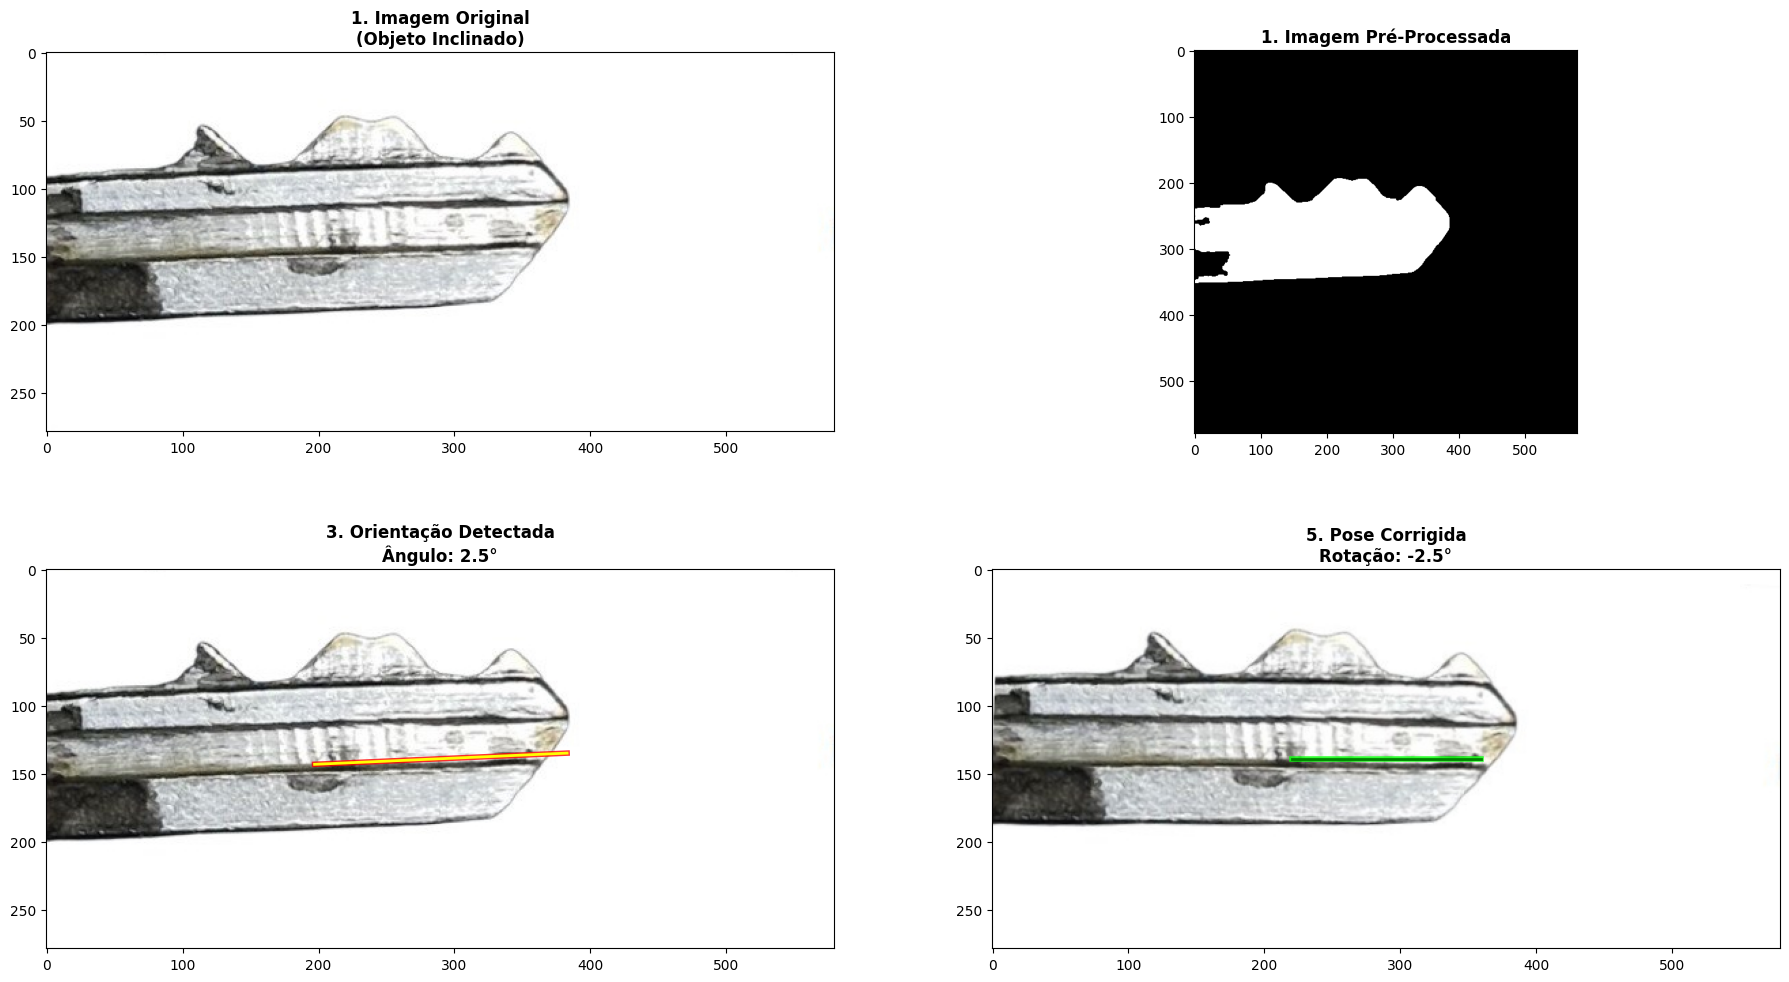

In [ ]:
image = cv2.imread('../../../../imgs/private/2b.jpg', cv2.IMREAD_COLOR)
object = get_main_object(image)

detected_angle = orientation_from_fourier_paper(object, xi_min_ratio=0.05)

corrected_image = correct_pose_to_horizontal(image, detected_angle)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Imagem Original
axes[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('1. Imagem Original\n(Objeto Inclinado)', fontsize=12, fontweight='bold')

# 2. Imagem Pré-Processada
axes[0,1].imshow(cv2.cvtColor(object, cv2.COLOR_BGR2RGB))
axes[0,1].set_title('1. Imagem Pré-Processada', fontsize=12, fontweight='bold')

# 3. Imagem com Ângulo Detectado
axes[1,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

h, w = image.shape[:2]
center = (w // 2, h // 2)
length = min(w, h) / 3
angle_rad = np.deg2rad(detected_angle)
x1 = center[0] - length * np.cos(angle_rad)
y1 = center[1] - length * np.sin(angle_rad)
x2 = center[0] + length * np.cos(angle_rad)
y2 = center[1] + length * np.sin(angle_rad)
axes[1,0].plot([x1, x2], [y1, y2], 'red', linewidth=4, alpha=0.8)
axes[1,0].plot([x1, x2], [y1, y2], 'yellow', linewidth=2)

axes[1,0].set_title(f'3. Orientação Detectada\nÂngulo: {-detected_angle:.1f}°', 
                    fontsize=12, fontweight='bold')

# 4. Resultado Final
axes[1,1].imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

ch, cw = corrected_image.shape[:2]
center_c = (cw // 2, ch // 2)
length_c = min(cw, ch) / 4
axes[1,1].plot([center_c[0] - length_c, center_c[0] + length_c], 
                [center_c[1], center_c[1]], 'lime', linewidth=4, alpha=0.8)
axes[1,1].plot([center_c[0] - length_c, center_c[0] + length_c], 
                [center_c[1], center_c[1]], 'green', linewidth=2)

axes[1,1].set_title(f'5. Pose Corrigida\nRotação: {detected_angle:.1f}°', 
                    fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.15, hspace=0.35, wspace=0.2) 
plt.show()

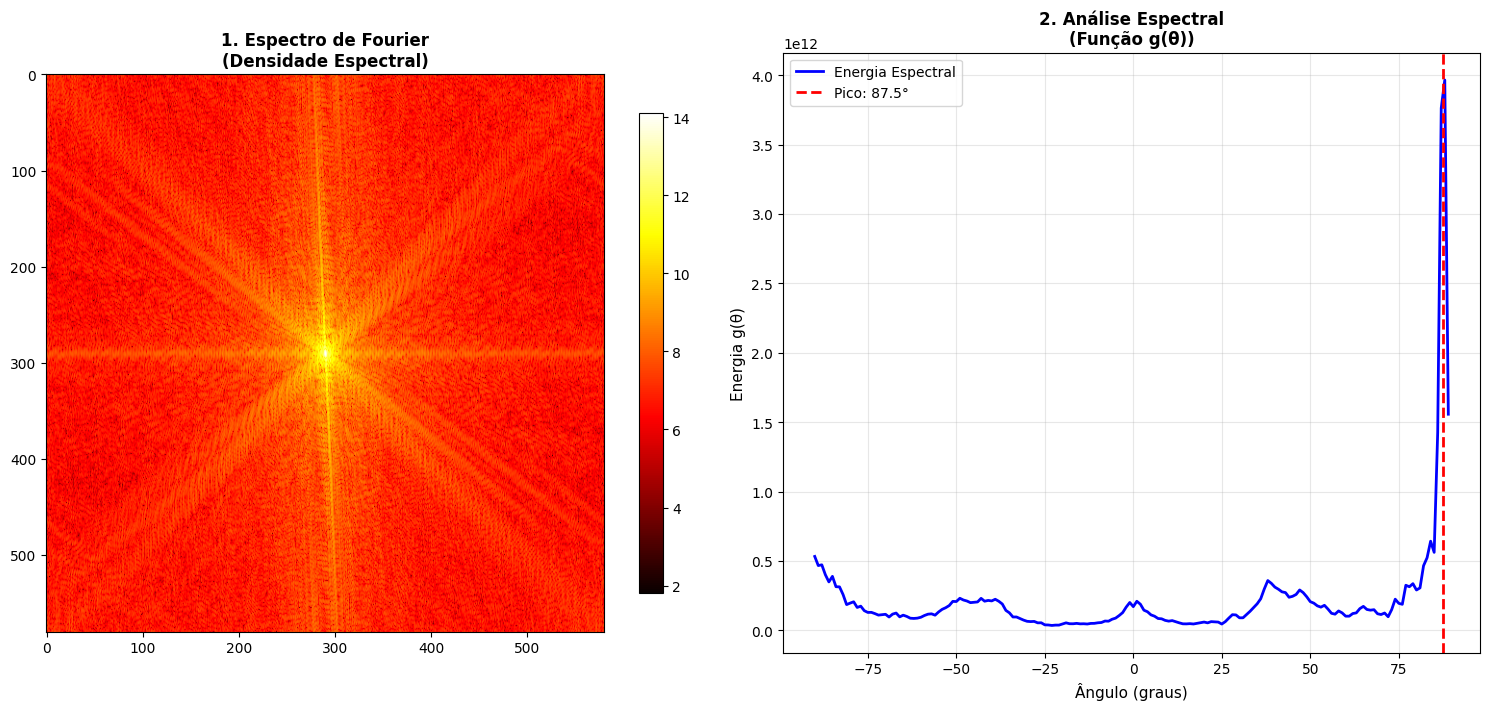

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# 1. Espectro de Fourier
fft_result = np.fft.fftshift(np.fft.fft2(object))
psd = np.abs(fft_result)**2
psd_log = np.log10(psd + 1)
im = axes[0].imshow(psd_log, cmap='hot')
axes[0].set_title('1. Espectro de Fourier\n(Densidade Espectral)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[0], shrink=0.8)

# 2. Espectro Filtrado
h_obj, w_obj = object.shape
center_x, center_y = w_obj // 2, h_obj // 2
y, x = np.ogrid[-center_y:h_obj-center_y, -center_x:w_obj-center_x]
dist_from_center = np.sqrt(x**2 + y**2)

xi_min = 0.05 * max(h_obj, w_obj)
n_max = min(center_x, center_y)
mask = (dist_from_center >= xi_min) & (dist_from_center <= n_max)
filtered_psd = psd * mask

# filtered_psd_log = np.log10(filtered_psd + 1)
# im2 = axes[1].imshow(filtered_psd_log, cmap='hot', origin='upper')
# axes[1].set_title('2. Espectro Filtrado (log₁₀)', fontsize=12, fontweight='bold')
# plt.colorbar(im2, ax=axes[1], label='log₁₀(Densidade Filtrada)')

# 3. Função g(θ) - Energia por Direção
# Recalcular para plotar g(theta)
angles = np.arange(-90, 90, 1.0)
g_theta = np.zeros(len(angles))

Y, X = np.ogrid[-center_y:h_obj-center_y, -center_x:w_obj-center_x]
theta_grid_deg = np.rad2deg(np.arctan2(Y, X))

for i, target_angle in enumerate(angles):
    angle_diff = np.abs(theta_grid_deg - target_angle)
    mask1 = angle_diff <= 0.75
    
    symmetric_angle = target_angle + 180 if target_angle < 0 else target_angle - 180
    angle_diff_sym = np.abs(theta_grid_deg - symmetric_angle)
    mask2 = angle_diff_sym <= 0.75
    
    angle_mask = mask1 | mask2
    combined_mask = mask & angle_mask
    g_theta[i] = np.sum(filtered_psd[combined_mask])

spectrum_angle = detected_angle + 90 

axes[1].plot(angles, g_theta, 'b-', linewidth=2, label='Energia Espectral')
axes[1].axvline(spectrum_angle, color='red', linestyle='--', linewidth=2, 
                    label=f'Pico: {spectrum_angle:.1f}°')
axes[1].set_xlabel('Ângulo (graus)', fontsize=11)
axes[1].set_ylabel('Energia g(θ)', fontsize=11)
axes[1].set_title('2. Análise Espectral\n(Função g(θ))', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.15)
plt.show()